In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import cm, pyplot as plt 
import seaborn as sns

In [2]:
raw_df = pd.read_csv('../Data/Raw_data/AirBnB_data.csv')
raw_df = raw_df[['Reporting Month', 'Dong_name', 'Gu_name', 'Reservation Days', 'Revenue (USD)', 'Number of Reservations']]

raw_df['Reporting Month'] = pd.to_datetime(raw_df['Reporting Month'])

# 라벨을 뭘로 설정할 것인가?
label_df = raw_df.groupby(['Reporting Month', 'Dong_name']).agg({
    'Reservation Days': 'sum',
    'Revenue (USD)': 'sum',
    'Number of Reservations': 'sum'
}).reset_index()

label_df['count'] = raw_df.groupby(['Reporting Month', 'Dong_name']).size().values

dong_names = list(label_df['Dong_name'].unique())
dong_names.append('상계8동')   # 데이터가 없는 동 추가

# 비어있는 시간 기간 채우기
date_range = pd.date_range(start='2017-01-01', end='2022-07-01', freq='MS')
date_range = date_range.strftime('%Y-%m-%d')
full_index = pd.MultiIndex.from_product([date_range, dong_names], names=['Reporting Month', 'Dong_name'])
full_df = pd.DataFrame(index=full_index).reset_index()
full_df['Reporting Month'] = pd.to_datetime(full_df['Reporting Month'], errors='coerce')

label_df = pd.merge(full_df, label_df, on=['Reporting Month', 'Dong_name'], how='left')
label_df.fillna(0, inplace=True)
label_df

/tmp/ipykernel_388951/3039345824.py:1: DtypeWarning: Columns (4,9,11,12,13,23,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('../Data/Raw_data/AirBnB_data.csv')


,Reporting Month,Dong_name,Reservation Days,Revenue (USD),Number of Reservations,count
0,2017-01-01,가락1동,0.0,0.00,0.0,5.0
1,2017-01-01,가락2동,0.0,0.00,0.0,3.0
2,2017-01-01,가락본동,92.0,4319.67,30.0,17.0
3,2017-01-01,가리봉동,7.0,515.00,5.0,5.0
4,2017-01-01,가산동,0.0,0.00,0.0,9.0
...,...,...,...,...,...,...
28403,2022-07-01,중계4동,20.0,611.00,5.0,3.0
28404,2022-07-01,독산3동,151.0,4605.00,28.0,47.0
28405,2022-07-01,창2동,34.0,804.67,5.0,5.0
28406,2022-07-01,시흥4동,0.0,0.00,0.0,1.0


In [3]:
def make_heatmap(corr_matrix, x_labels=None, y_labels=None, threshold=0.1):
    """
    상관 행렬 히트맵을 생성하며, 특정 threshold 이상의 상관관계를 가지는 y축 변수만 선택하여 반환.

    Parameters:
        corr_matrix (pd.DataFrame): 상관계수 행렬
        x_labels (list): x축 레이블에 사용할 변수 리스트 (기본값: None → 자동 설정)
        y_labels (list): y축 레이블에 사용할 변수 리스트 (기본값: None → 자동 설정)
        threshold (float): 특정 상관계수 이상인 변수만 필터링 (기본값: 0.1)
    
    Returns:
        filtered_y_labels (list): corr_matrix에서 threshold 이상인 y축 변수 목록
    """
    
    # 지정된 x_labels와 y_labels에 대해 상관 행렬 추출
    selected_corr = corr_matrix.loc[y_labels, x_labels]
    
    # 0.1보다 큰 y축 변수 찾기 (y_labels 중에서 x_labels와 0.1 이상인 값이 있는 것)
    filtered_y_labels = selected_corr.index[(selected_corr.abs() > threshold).any(axis=1)].tolist()

    # 필터링된 y_labels로 다시 행렬 선택
    selected_corr = selected_corr.loc[filtered_y_labels, :]

    # 히트맵 생성
    plt.figure(figsize=(max(10, len(x_labels) * 0.5), max(10, len(filtered_y_labels) * 0.5)))
    sns.heatmap(selected_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
                xticklabels=x_labels, yticklabels=filtered_y_labels)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

    return filtered_y_labels  # threshold 이상인 y축 변수 반환

In [4]:
hf = pd.read_csv('../Data/Preprocessed_data/Dong/Human_flow.csv')
road = pd.read_csv('../Data/Preprocessed_data/Dong/Road_Embeddings_with_flow.csv')

hf['Reporting Month'] = pd.to_datetime(hf['Reporting Month'])
road['Reporting Month'] = pd.to_datetime(road['Reporting Month'])

road = road.rename(columns={'승차총승객수(버스)': 'Total Boarding Passengers (Bus)', 
                        '하차총승객수(버스)': 'Total Alighting Passengers (Bus)',
                        '승차총승객수(지하철)': 'Total Boarding Passengers (Subway)', 
                        '하차총승객수(지하철)': 'Total Alighting Passengers (Subway)'})

In [5]:
hf_cols = list(hf.columns)[2:]
road_cols = list(road.columns)[2:]
label_cols = ['Reservation Days', 'Revenue (USD)', 'Number of Reservations']

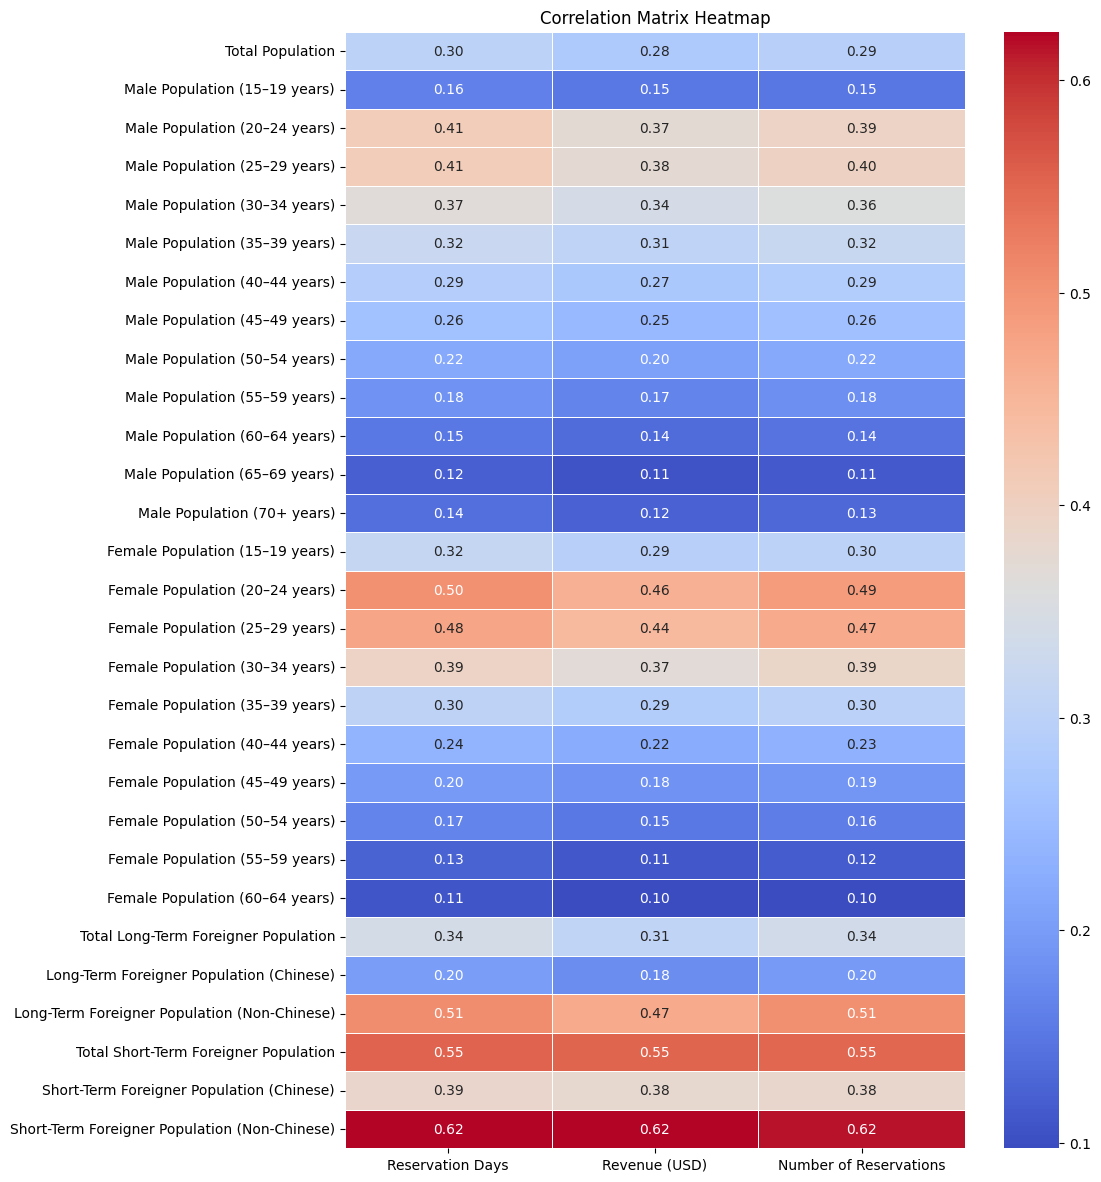

35
29


In [6]:
hf_label = pd.merge(hf, label_df, on=['Reporting Month', 'Dong_name'], how='inner')

corr_matrix = hf_label.iloc[:, 2:].corr()
cor_cols_hf = make_heatmap(corr_matrix, label_cols, hf_cols)
print(len(hf_cols))
print(len(cor_cols_hf))

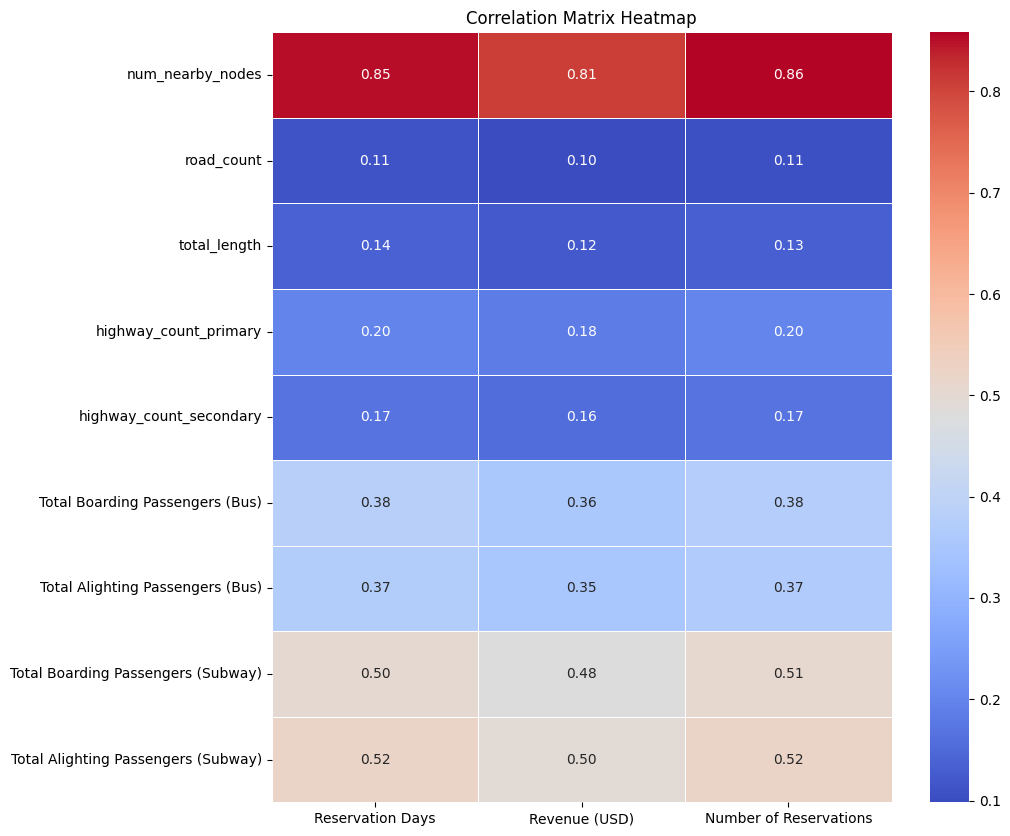

28
9


In [7]:
road_label = pd.merge(road, label_df, on=['Reporting Month', 'Dong_name'], how='inner')

corr_matrix = road_label.iloc[:, 2:].corr()
cor_cols_road = make_heatmap(corr_matrix, label_cols, road_cols)
print(len(road_cols))
print(len(cor_cols_road))

In [8]:
cor_cols_hf = ['Reporting Month', 'Dong_name'] + cor_cols_hf
cor_cols_road = ['Reporting Month', 'Dong_name'] + cor_cols_road

In [9]:
flow_df = pd.merge(hf[cor_cols_hf], road[cor_cols_road], on=['Reporting Month', 'Dong_name'], how='inner')
flow_df

,Reporting Month,Dong_name,Total Population,Male Population (15–19 years),Male Population (20–24 years),Male Population (25–29 years),Male Population (30–34 years),Male Population (35–39 years),Male Population (40–44 years),Male Population (45–49 years),...,Short-Term Foreigner Population (Non-Chinese),num_nearby_nodes,road_count,total_length,highway_count_primary,highway_count_secondary,Total Boarding Passengers (Bus),Total Alighting Passengers (Bus),Total Boarding Passengers (Subway),Total Alighting Passengers (Subway)
0,2017-01-01,청운효자동,15948.599397,358.376044,664.463461,710.623451,661.017397,735.452707,725.818336,726.285422,...,377.990055,177.0,102,15032.778,0.0,0.0,183338,202583,0.0,0.0
1,2017-01-01,사직동,32795.242545,339.376079,996.575257,1426.200734,1769.883440,2024.692921,1977.021621,2006.853506,...,1282.026911,337.0,214,22040.495,45.0,0.0,632595,689110,1754715.0,1807322.0
2,2017-01-01,삼청동,6013.897520,183.644499,245.499676,330.121580,309.305424,315.273764,294.380248,306.167892,...,345.499791,34.0,17,3477.422,2.0,0.0,106233,122132,0.0,0.0
3,2017-01-01,부암동,11578.176069,311.245012,486.469254,367.300544,284.469658,355.809420,347.275677,480.086055,...,218.504588,194.0,375,36188.775,12.0,24.0,277127,258524,0.0,0.0
4,2017-01-01,평창동,22895.411724,576.485647,721.384081,585.131328,520.835537,623.357402,678.007431,872.954451,...,186.040345,119.0,717,74985.331,37.0,0.0,284402,251046,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28403,2022-07-01,약수동,14530.991262,220.915889,316.410444,431.390072,471.237186,612.730659,625.829563,585.373675,...,101.108968,25.0,176,11215.431,0.0,13.0,111302,109666,524524.0,512251.0
28404,2022-07-01,광희동,23176.182660,346.660967,859.078941,1058.326832,1119.076395,1372.993161,1182.074563,1283.869899,...,1896.300547,2664.0,522,29900.887,9.0,133.0,383627,363379,0.0,0.0
28405,2022-07-01,이문1동,22796.005607,796.616554,2115.262178,1551.900051,799.507856,682.307138,599.641210,679.439997,...,55.502406,506.0,704,35300.705,0.0,55.0,196996,213755,215349.0,212444.0
28406,2022-07-01,장위1동,20724.229083,561.444333,612.303204,572.497435,617.233835,768.737574,745.322060,756.070144,...,23.452700,64.0,998,44156.095,0.0,14.0,266569,240214,0.0,0.0


In [10]:
# HF + Road 더하기
flow_df.to_csv('../Data/Preprocessed_data/Dong/flow.csv', index=False)

# AirBnB 주 활동지역의 차이 확인

In [11]:
many_names = list(pd.read_csv('../Data/Preprocessed_data/many_dong_names.csv')['Dong_name'])
#many_names

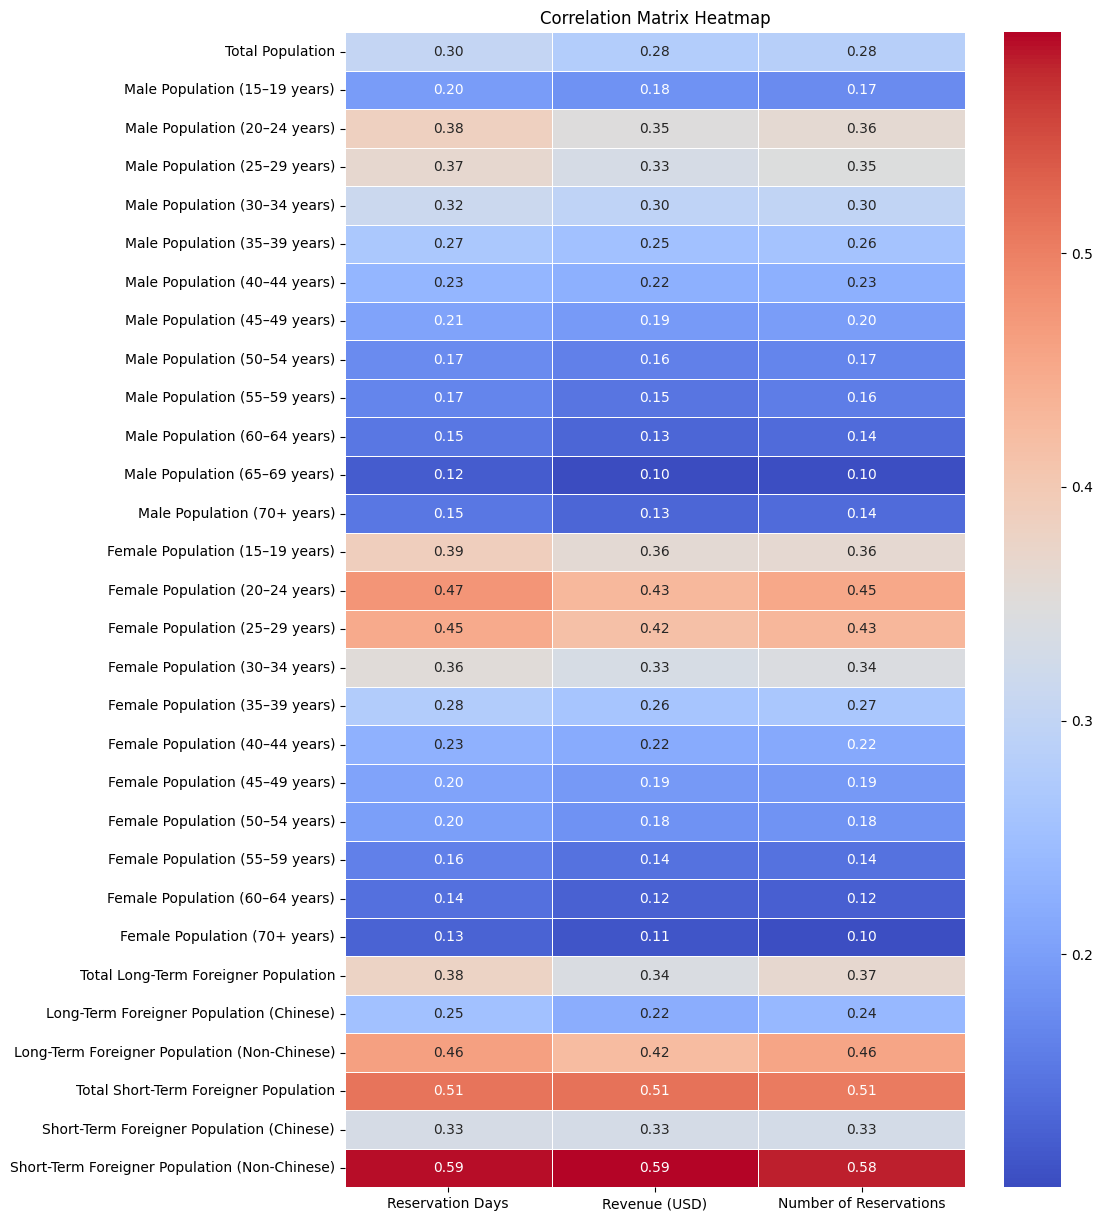

['Total Population',
 'Male Population (15–19 years)',
 'Male Population (20–24 years)',
 'Male Population (25–29 years)',
 'Male Population (30–34 years)',
 'Male Population (35–39 years)',
 'Male Population (40–44 years)',
 'Male Population (45–49 years)',
 'Male Population (50–54 years)',
 'Male Population (55–59 years)',
 'Male Population (60–64 years)',
 'Male Population (65–69 years)',
 'Male Population (70+ years)',
 'Female Population (15–19 years)',
 'Female Population (20–24 years)',
 'Female Population (25–29 years)',
 'Female Population (30–34 years)',
 'Female Population (35–39 years)',
 'Female Population (40–44 years)',
 'Female Population (45–49 years)',
 'Female Population (50–54 years)',
 'Female Population (55–59 years)',
 'Female Population (60–64 years)',
 'Female Population (70+ years)',
 'Total Long-Term Foreigner Population',
 'Long-Term Foreigner Population (Chinese)',
 'Long-Term Foreigner Population (Non-Chinese)',
 'Total Short-Term Foreigner Population',
 '

In [12]:
many_hf_label = hf_label[hf_label['Dong_name'].isin(many_names)]
corr_matrix = many_hf_label.iloc[:, 2:].corr()
make_heatmap(corr_matrix, label_cols, hf_cols)

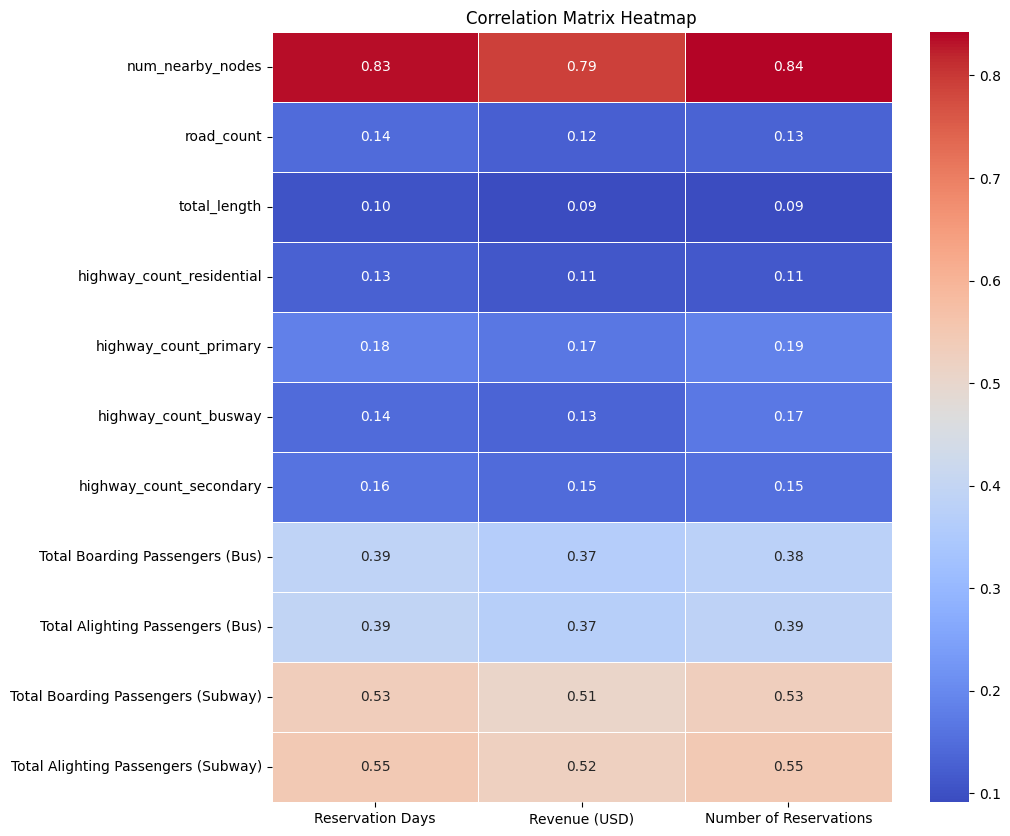

['num_nearby_nodes',
 'road_count',
 'total_length',
 'highway_count_residential',
 'highway_count_primary',
 'highway_count_busway',
 'highway_count_secondary',
 'Total Boarding Passengers (Bus)',
 'Total Alighting Passengers (Bus)',
 'Total Boarding Passengers (Subway)',
 'Total Alighting Passengers (Subway)']

In [13]:
many_road_label = road_label[road_label['Dong_name'].isin(many_names)]
corr_matrix = many_road_label.iloc[:, 2:].corr()
make_heatmap(corr_matrix, label_cols, road_cols)

In [14]:
def plot_dong_time_series(df1, y, y_opt = None):
    plt.rc('font', family='NanumGothic')
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, ax = plt.subplots(figsize=(12, 6))  # 하나의 그래프만 그리도록 변경
    
    # 25개의 색상을 생성하기 위해 컬러맵 설정
    colors = cm.get_cmap('tab20', 25)  # 25개의 색상 생성

    # 변수(y) 기준 상위 10개 동 선택
    top_10_dongs_df1 = df1.groupby('Dong_name')[y].sum().nlargest(10).index
    
    # 첫 번째 데이터프레임 (df1)
    for idx, dong in enumerate(df1['Dong_name'].unique()):
        df_dong = df1[df1['Dong_name'] == dong]
        color = colors(idx % 25)

        # 상위 10개 동은 레전드 추가, 나머지는 투명도 적용
        if dong in top_10_dongs_df1:
            ax.plot(df_dong['Reporting Month'], df_dong[y], label=dong, marker='o', color=color)
        else:
            ax.plot(df_dong['Reporting Month'], df_dong[y], color=color, alpha=0.5)

    # 범례 추가
    ax.legend(title="Dong_name", bbox_to_anchor=(1.05, 1), loc='upper left')

    # y축 고정
    if y_opt != None:
        ax.set_ylim(y_opt)
    # 제목 및 축 레이블 추가
    ax.set_title(f"Time Series of {y} by Dong")
    ax.set_xlabel("Reporting Month")
    ax.set_ylabel(y)

    # 레이아웃 조정
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_388951/4031776321.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', 25)  # 25개의 색상 생성


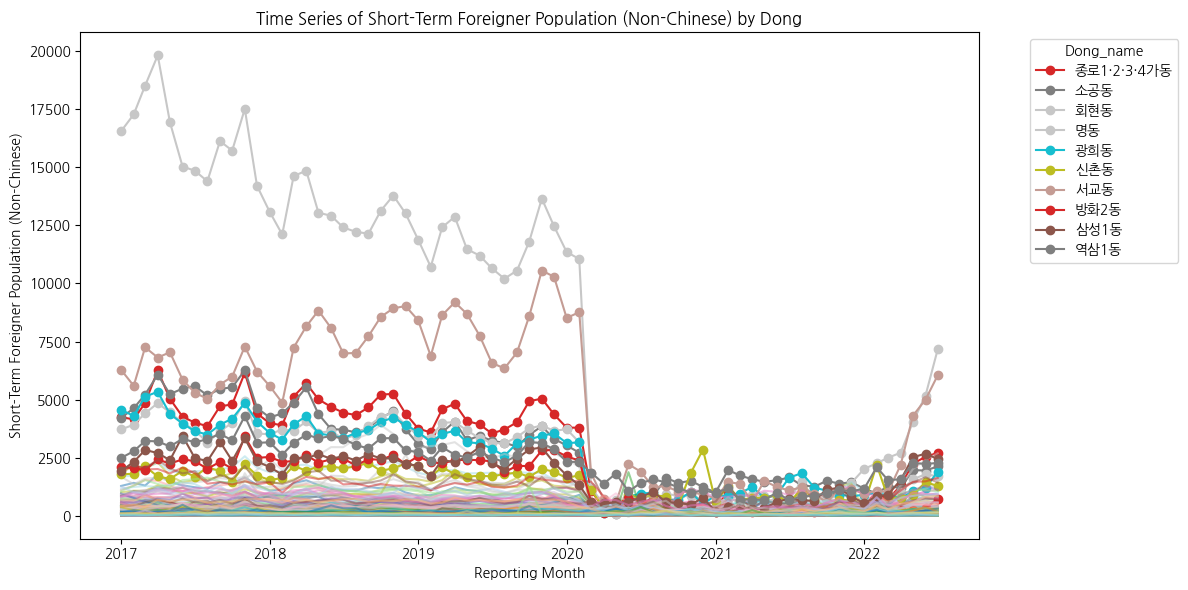

In [15]:
plot_dong_time_series(hf, 'Short-Term Foreigner Population (Non-Chinese)')

/tmp/ipykernel_388951/4031776321.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', 25)  # 25개의 색상 생성


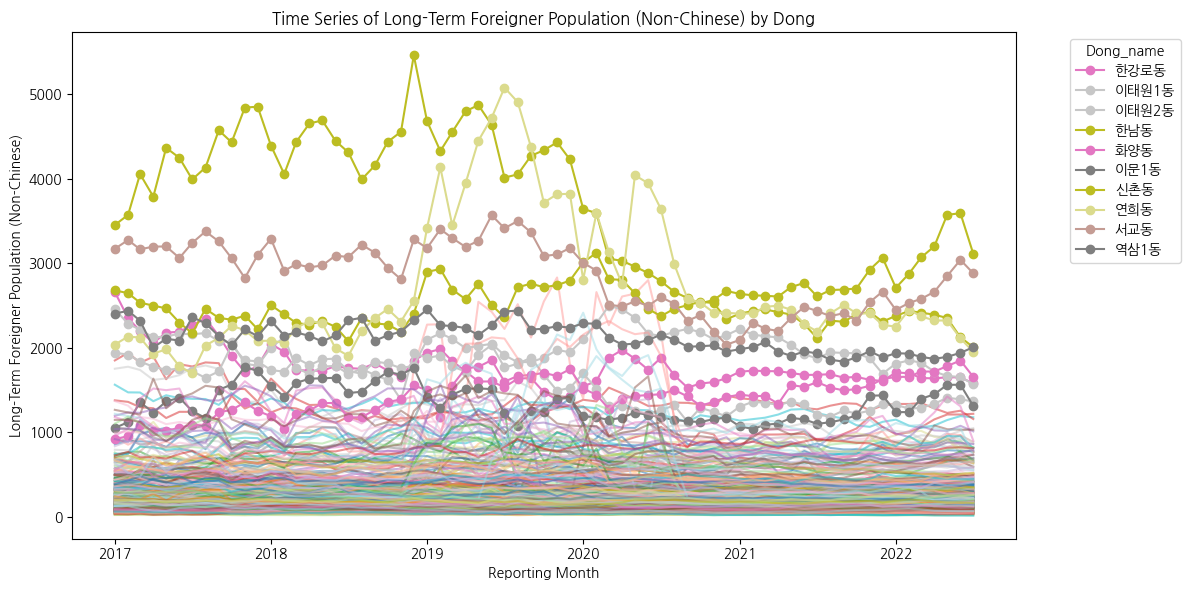

In [16]:
plot_dong_time_series(hf, 'Long-Term Foreigner Population (Non-Chinese)')